# CSC412/2506  Assignment 3: Variational Auto Encoders

In this assignment we will learn how to preform efficient inference and learning in directed graphical models with continuous latent variables.We will use stochastic variational inference with automatic differentiation (SADVI) to approximate intractible posterior distributions. 
We will implement the two gradient estimators discussed in lecture, Score Function and Reparamterization, and experimentally demonstrate their properties such as biasedness and variance. 
We will use the reparameterization gradient estimators to optimize the ELBO of our latent variable model.

You can use automatic differentiation in your code.
You may also use a machine learning framework to specify the encoder and decoder neural networks, and provide gradientent optimizers such as ADAM.
However, you may not use any probabilistic modelling elements for these frameworks.
In particular, sampling from and evaluating densities under distributions must be written by you.

# Implementing the VAE

In this assignment we will implement and investigate the Variational Auto Encoder on Binarized MNIST digits detailed in [Auto-Encoding Bariational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013). Before starting, read this paper. In particular, we will implement model as described in Appendix C.

## Load and Prepare Data

Load the MNIST dataset, binarize the images, split into a training dataset of 10000 images and a test set of 10000 images. Also partition the training set into minibatches of size M=100.

In [1]:
!pip3 install torch

Error checking for conflicts.
Traceback (most recent call last):
  File "/home/goj/.conda/envs/PDSH/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2584, in version
    return self._version
  File "/home/goj/.conda/envs/PDSH/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _version

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/goj/.conda/envs/PDSH/lib/python3.5/site-packages/pip/_internal/commands/install.py", line 503, in _warn_about_conflicts
    package_set, _dep_info = check_install_conflicts(to_install)
  File "/home/goj/.conda/envs/PDSH/lib/python3.5/site-packages/pip/_internal/operations/check.py", line 108, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
  File "/home/goj/.conda/envs/PDSH/lib/python3.5/site-packages/pip/_internal/operations/check.py", line

In [2]:

import numpy as np
import os
import gzip
import struct
import array
import math

import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.autograd import Variable
from autograd import grad

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels


def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


In [3]:
N_data, train_images, train_labels, test_images, test_labels = load_mnist()
train_images = np.round(train_images[0:10000])
train_labels = train_labels[0:10000]
test_images = np.round(test_images[0:10000])

train_images = Variable(torch.from_numpy(train_images))
train_labels = Variable(torch.from_numpy(train_labels))
test_images = Variable(torch.from_numpy(test_images))
test_labels = Variable(torch.from_numpy(test_labels))

## Distributions

Implement code to sample from and evaluate the log-pdf of diagonal multivariate gaussians $\mathcal{N}(x|\mu, \sigma I)$ and Bernoulli distributions. For sampling from these distributions, you have access to samples from uniform and unit Gaussians, (`rand` and `randn`). Make sure you test you've implemented these correctly by comparing to standard packages!

In [4]:
# sampler from Diagonal Gaussian x~N(Î¼,ÏƒI) (hint: use reparameterization trick here)
def sample_gaussian(mu, log_sigma_squared):
    return mu + torch.exp(log_sigma_squared*0.5)*torch.randn(log_sigma_squared.size())

# sampler from Bernoulli
def sample_bernoulli(theta):
    s = torch.rand(theta.shape)
    n = len(theta.size())
    if n == 1:
        for i in range (0, s.shape[0]):
            if s[i] <= theta[i]:
                s[i] = 1
            else:
                s[i] = 0
    else:
        for i in range(0, s.shape[0]):
            for j in range(0, s.shape[1]):
                if s[i][j] <= theta[i][j]:
                    s[i][j] = 1
                else:
                    s[i][j] = 0
    return s

# log-pdf of x under Diagonal Gaussian N(x|Î¼,ÏƒI)
def log_pdf_gaussian(x, mu, log_sigma_squared):
    sigma_squared = torch.exp(log_sigma_squared)
    log_prob = -1 * torch.sum(((x - mu) ** 2) / (2 * sigma_squared) + torch.log((2 * torch.tensor(math.pi) * sigma_squared) ** 0.5), dim=1)
    return log_prob

# log-pdf of x under Bernoulli 
def log_pdf_bernoulli(x, theta):
    return torch.sum(x * torch.log(theta) + (1 - x) * torch.log(1 - theta), dim = 1)


## Defining Model Architecture

Implement the model as defined in Appendix C. The MLPs will have a single hidden layer with Dh=500 hidden units. The dimensionality of the latent space will be Dz=2 for visualization purposes later.

Note that the output of the encoder will be $[\mu,\log\sigma]$. Why not ouput $\sigma$ directly? Keep this in mind when you sample from the distribution using your Diagonal Gaussian sampler.

In [5]:
# Set latent dimensionality=2 and number of hidden units=500.
latent_size = 2
hidden_size = 500
input_size = train_images.shape[1]

# Define MLP for recognition model / "encoder"
# Provides parameters for q(z|x)
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.W3 = nn.Linear(input_size, hidden_size)
        self.W4 = nn.Linear(hidden_size, output_size)
        self.W5 = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        h = torch.tanh(self.W3(inputs))
        mu = self.W4(h)
        log_sigma_squared = self.W5(h)
        return mu, log_sigma_squared

encoder = Encoder(input_size, hidden_size, latent_size)


# Define sample from recognition model
# Samples z ~ q(z|x)
def sample_z(mu, sigma):
    return sample_gaussian(mu, sigma)


# Define MLP for generative model / "decoder"
# Provides parameters for distribution p(x|z)
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.W1 = nn.Linear(input_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        h = torch.tanh(self.W1(inputs))
        y = self.W2(h)
        y = torch.sigmoid(y)
        return y
      
decoder = Decoder(latent_size, hidden_size, input_size)

## Variational Objective

Here we will use the log-pdfs, the encoder, gaussian sampler, and decoder to define the Monte Carlo estimator for the mean of the ELBO over the minibatch.

In [6]:
# log_q(z|x) logprobability of z under approximate posterior N(Î¼,Ïƒ)
def log_z_post(z, mu, log_sigma_squared):
    return log_pdf_gaussian(z, mu, log_sigma_squared)

# log_p_z(z) log probability of z under prior
def log_z_prior(z):
    mu = torch.zeros(z.size())
    log_sigma_squared = torch.log(torch.ones(z.size()))
    return log_pdf_gaussian(z, mu, log_sigma_squared)

# log_p(x|z) - conditional probability of data given latents.
def log_cond_x(x, theta):
    return log_pdf_bernoulli(x, theta)

# Monte Carlo Estimator of mean ELBO with Reparameterization over M minibatch samples.
# This is the average ELBO over the minibatch
# Unlike the paper, do not use the closed form KL between two gaussians,
# Following eq (2), use the above quantities to estimate ELBO as discussed in lecture
def monte_carlo_estimate(batch_x, batch_z, batch_theta, batch_mu, batch_log_sigma_squared):
    log_p_x_z = log_cond_x(batch_x, batch_theta) + log_z_prior(batch_z)
    log_q_x_z = log_z_post(batch_z, batch_mu, batch_log_sigma_squared)
    return -1 * torch.mean(log_p_x_z - log_q_x_z)

## Optimize with Gradient Descent

Minimize the -ELBO with ADAM optimizer. You may use the optimizer provided by your framework

In [7]:
# Load Saved Model Parameters (if you've already trained)
# model = encoder_decoder(encoder, decoder)
# forward = model(Variable(torch.from_numpy(train_images), requires_grad=False).type(torch.FloatTensor))

In [8]:
batch_size = 100
num_batches = int(np.ceil(len(train_images) / batch_size))

def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

def batched_loss(batch, encoder, decoder):
    mu, log_sigma_squared = encoder(batch)
    latent_codes = sample_z(mu, log_sigma_squared)
    thetas = decoder(latent_codes)

    return monte_carlo_estimate(batch, latent_codes, thetas, mu, log_sigma_squared)

# Set up ADAM optimizer
grads = grad(batched_loss)
encoder_optimizer = torch.optim.Adam(encoder.parameters() , lr=0.001)
decoder_optimizer = torch.optim.Adam(decoder.parameters() , lr=0.001)

# Train for ~200 epochs (1 epoch = all minibatches in traindata)
for i in range(200):
    print("Iteration: " + str(i + 1))
    for j in range(num_batches):
        batch = train_images[batch_indices(j)].float()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = batched_loss(batch, encoder, decoder)
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
    print("Loss: " + str(loss))

Iteration: 1
Loss: tensor(188.8735, grad_fn=<MulBackward0>)
Iteration: 2
Loss: tensor(183.5823, grad_fn=<MulBackward0>)
Iteration: 3
Loss: tensor(180.8961, grad_fn=<MulBackward0>)
Iteration: 4
Loss: tensor(178.3251, grad_fn=<MulBackward0>)
Iteration: 5
Loss: tensor(175.5376, grad_fn=<MulBackward0>)
Iteration: 6
Loss: tensor(172.7180, grad_fn=<MulBackward0>)
Iteration: 7
Loss: tensor(170.1824, grad_fn=<MulBackward0>)
Iteration: 8
Loss: tensor(167.9482, grad_fn=<MulBackward0>)
Iteration: 9
Loss: tensor(166.0396, grad_fn=<MulBackward0>)
Iteration: 10
Loss: tensor(164.1208, grad_fn=<MulBackward0>)
Iteration: 11
Loss: tensor(163.4699, grad_fn=<MulBackward0>)
Iteration: 12
Loss: tensor(161.6849, grad_fn=<MulBackward0>)
Iteration: 13
Loss: tensor(160.6356, grad_fn=<MulBackward0>)
Iteration: 14
Loss: tensor(160.2975, grad_fn=<MulBackward0>)
Iteration: 15
Loss: tensor(159.3268, grad_fn=<MulBackward0>)
Iteration: 16
Loss: tensor(158.8231, grad_fn=<MulBackward0>)
Iteration: 17
Loss: tensor(158.28

Loss: tensor(134.5986, grad_fn=<MulBackward0>)
Iteration: 136
Loss: tensor(135.0815, grad_fn=<MulBackward0>)
Iteration: 137
Loss: tensor(134.5643, grad_fn=<MulBackward0>)
Iteration: 138
Loss: tensor(134.2342, grad_fn=<MulBackward0>)
Iteration: 139
Loss: tensor(134.4643, grad_fn=<MulBackward0>)
Iteration: 140
Loss: tensor(134.0035, grad_fn=<MulBackward0>)
Iteration: 141
Loss: tensor(133.9592, grad_fn=<MulBackward0>)
Iteration: 142
Loss: tensor(134.3953, grad_fn=<MulBackward0>)
Iteration: 143
Loss: tensor(136.8582, grad_fn=<MulBackward0>)
Iteration: 144
Loss: tensor(136.8202, grad_fn=<MulBackward0>)
Iteration: 145
Loss: tensor(136.0258, grad_fn=<MulBackward0>)
Iteration: 146
Loss: tensor(141.2135, grad_fn=<MulBackward0>)
Iteration: 147
Loss: tensor(136.2224, grad_fn=<MulBackward0>)
Iteration: 148
Loss: tensor(134.3853, grad_fn=<MulBackward0>)
Iteration: 149
Loss: tensor(135.3540, grad_fn=<MulBackward0>)
Iteration: 150
Loss: tensor(135.8429, grad_fn=<MulBackward0>)
Iteration: 151
Loss: te

In [9]:
# Save Optimized Model Parameters

## Report ELBO on Training and Test Set

In [10]:
# ELBO on training set
print("The ELBO on the Training Set is: ")
print(batched_loss(train_images.float(), encoder, decoder))
# ELBO on test set
print("The ELBO on the Test Set is: ")
print(batched_loss(test_images.float(), encoder, decoder))

The ELBO on the Training Set is: 
tensor(144.2041, grad_fn=<MulBackward0>)
The ELBO on the Test Set is: 
tensor(158.7220, grad_fn=<MulBackward0>)


# Numerically Computing Intractable Integrals

## Numerical Integration over Latent Space

Since we chose a low dimensional latent space, we are able to perform [numerical integration](https://en.wikipedia.org/wiki/Riemann_sum) to evaluate integrals which are intractible in higher dimension. 

For instance, we will use this to integrate over the latent space. e.g. the $$p(z|x) = \frac{p(x|z)*p(z)}{p(x)}= \frac{p(x|z)*p(z)}{\int p(x|z)*p(z) dz}$$

We want to numerically compute that integral. However, since we are parameterizing $\log p(x|z)$ and $\log p(z)$ we will have
$$\log p(z|x) = \log p(x|z) + \log p(z) - \log \int \exp [\log p(x|z)+ \log p(z)] dz$$

You will write code which computes $\log \int \exp \log f(z) dz$ given an equally spaced  grid of $\log f(z)$s as input.
Note that if we approximate that integral with a numerical sum, in order for it to be numerical we will need `logsumexp`.

In [11]:
# from scipy.misc import logsumexp
# Implement log sum exp
def logsumexp(x):
    shift = torch.max(x)
    return torch.log(torch.sum(torch.exp(x - shift))) + shift

# Implement stable numerical integration 
# over a 2d grid of equally spaced (delta_z) evaluations logf(x)
def numerical_integration(i, delta_z):
    return logsumexp(i + 2 * np.log(delta_z))

## Compare Numerical Log-Likelihood to ELBO

We can use the numerical integration to compute the log-likeihood of a element in our dataset under our model. We can then compare the numerical integration to the estimate given by the ELBO.

In [12]:
# Define the delta_z to be the spacing of the grid  (I used delta_z = 0.1)
delta_z = 0.1

# Define a grid of delta_z spaced points [-4,4]x[-4,4]
# grid = torch.ones([81, 81, 2], dtype = torch.float64)
start, end = -4, 4
size = int((end - start) / delta_z) + 1

grid = np.linspace(start, end, size)
grid = np.transpose([np.tile(grid, len(grid)), np.repeat(grid, len(grid))])
grid = Variable(torch.from_numpy(grid)).float()

def print_elbo(n):
    for i in range(n):
        # Sample an x from the data to evaluate the likelhiood
        x = train_images[np.random.randint(low = 0, high = len(train_images))].float().unsqueeze(dim=0)

        # Compute log_p(x|z)+log_p(z) for every point on the grid
        thetas = decoder(grid)
        probs = log_z_prior(grid) + log_cond_x(x, thetas)
        
        # # Using your numerical integration code
        # # integrate log_p(x|z)+log_p(z) over z to find log_p(x)
        p_x = numerical_integration(probs, delta_z)
        print("Log evidence: " + str(p_x))

        # Check that your numerical integration is correct 
        # by integrating log_p(x|z)+log_p(z) - log_p(x)
        # If you've successfully normalized this should integrate to 0 = log 1
        print(numerical_integration(probs - p_x, delta_z))

        # # Now compute the ELBO on x
        print("ELBO on x iteration {}: {}".format(i, -1 * batched_loss(x, encoder, decoder)))

print("First RUN")
print_elbo(1)
print("Multiple samples of x")
# Try this for multiple samples of x
# note that the ELBO is a lower bound to the true log_p(x)!
print_elbo(10)

First RUN
Log evidence: tensor(-123.6838, grad_fn=<AddBackward0>)
tensor(2.2650e-06, grad_fn=<AddBackward0>)
ELBO on x iteration 0: -125.33514404296875
Multiple samples of x
Log evidence: tensor(-137.5299, grad_fn=<AddBackward0>)
tensor(-1.1563e-05, grad_fn=<AddBackward0>)
ELBO on x iteration 0: -144.43646240234375
Log evidence: tensor(-140.9017, grad_fn=<AddBackward0>)
tensor(-1.0252e-05, grad_fn=<AddBackward0>)
ELBO on x iteration 1: -156.7532196044922
Log evidence: tensor(-37.4345, grad_fn=<AddBackward0>)
tensor(2.7418e-06, grad_fn=<AddBackward0>)
ELBO on x iteration 2: -38.09713363647461
Log evidence: tensor(-137.4136, grad_fn=<AddBackward0>)
tensor(-4.5300e-06, grad_fn=<AddBackward0>)
ELBO on x iteration 3: -150.97329711914062
Log evidence: tensor(-131.0292, grad_fn=<AddBackward0>)
tensor(-1.0610e-05, grad_fn=<AddBackward0>)
ELBO on x iteration 4: -135.02676391601562
Log evidence: tensor(-118.6162, grad_fn=<AddBackward0>)
tensor(1.6689e-06, grad_fn=<AddBackward0>)
ELBO on x iterat

# Data Space Visualizations

In this section we will investigate our model by visualizing the distributions over data given by the generative model, samples from these distributions, and reconstructions of the data.

In [13]:
# Write a function to reshape 784 array into a 28x28 image for plotting
def reshape(img):
    return img.view(28, 28)

# TODO: grab from src
def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
    cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    return cax

## Samples from the generative model

Here you will sample from the generative model using ancestral sampling. 

* First sample a z from the prior. 
* Then use the generative model to parameterize a bernoulli distribution over x given z. Plot this distribution.
* Then sample x from the distribution. Plot this sample.

Do this for 10 samples z from the prior.

Concatenate all your plots into one 10x2 figure where the first column is the distribution over x and the second column is a sample from this distribution. Each  row will be a new sample from the prior.

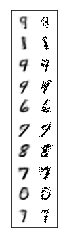

In [14]:
# Sample 10 z from prior
mu = torch.zeros(2)
sigma = torch.ones(2)
z_s = torch.stack([sample_z(mu, sigma) for _ in range(10)])

# For each z, plot p(x|z)
# for z in z_s
theta = decoder(z_s)
x_np = theta.data.numpy()

# Sample x from p(x|z)
x_s = sample_bernoulli(theta)
fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(1, 1, 1)

# Concatenate plots into a figure
stacked = np.concatenate([np.stack([x_np[i], x_s[i]]) for i in range(10)], axis=0)

plot_images(stacked, ax, ims_per_row=2)

## Reconstructions of data

Here we will investigate the VAEs ability to reconstruct 10 inputs from the data. For each input ou will

* Plot the input $x$
* Use the recognition network to encode $x$ to the parameters for a distribution $q(z|x)$
* Sample $z \sim q(z|x)$
* Use the generative model to decode to the parameters for distribution $p(x|z)$. Plot this
* Sample $\tilde x \sim p(x|z)$. Plot this

Then you will concatenate all your plots into a 10x3 figure where the first column is the input data, the second column is the distribution over x, the third column is a reconstruction of the input. Each row will be a new sample from the data.

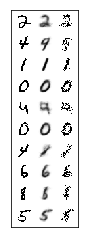

In [15]:
# Sample 10 xs from the data, plot.
x_s = torch.stack([train_images[np.random.randint(low=0, high=len(train_images))].float() for i in range(10)])

# For each x, encode to distribution q(z|x)
mu, log_sigma_squared = encoder(x_s)

# For each x, sample distribution z ~ q(z|x)
z_s = sample_z(mu, log_sigma_squared)

# For each z, decode to distribution p(x̃|z), plot.
theta = decoder(z_s)
x_np = theta.data.numpy()

# For each x, sample from the distribution x̃ ~ p(x̃|z), plot.
gen_x = sample_bernoulli(theta)

# Concatenate all plots into a figure.
fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(1, 1, 1)
stacked = np.concatenate([np.stack([x_s[i].data.numpy(), x_np[i], gen_x[i]]) for i in range(10)], axis=0)

plot_images(stacked, ax, ims_per_row=3)


# Latent Space Visualizations

In this section we will investigate our model by visualizing the latent space through various methods. These will include encoding the data, decoding along a grid, and linearly interpolating between encdoded data.

## Latent embedding of data

One way to understand what is represented in the latent space is to consider where it encodes elements of the data. Here we will produce a scatter plot in the latent space, where each point in the plot will be the mean vector for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot by the class label for the input data. 

Hopefully our latent space will have learned to distinguish between elements from different classes, even though we never provided class labels to the model!

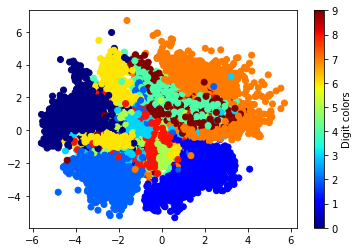

In [16]:
# Encode the training data
mu, log_sigma_squared = encoder(train_images.float())

# Take the mean vector of each encoding
mu = mu.data.numpy()
labels = np.argmax(train_labels.data.numpy(), axis =1)


# Plot these mean vectors in the latent space with a scatter
# Colour each point depending on the class label
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
plt.scatter(mu[:,0], mu[:,1], c=labels, cmap =cmap)
# TODO: which # is which
cb = plt.colorbar(spacing='proportional')
cb.set_label('Digit colors')

plt.show()

## Decoding along a lattice

We can also understand the "learned manifold" by plotting the generative distribution $p(x|z)$ for each point along a grid in the latent space. We will replicate figure 4b in the paper.

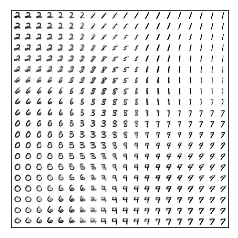

In [17]:
# Create a 20x20 equally spaced grid of z's
# (use the  previous figure to help you decide appropriate bounds for the grid)
start, end, size = -3, 3, 20
grid = np.linspace(start, end, size)
grid = np.transpose([np.tile(grid, len(grid)), np.repeat(grid, len(grid))])
grid = Variable(torch.from_numpy(grid)).float()

# For each z on the grid plot the generative distribution over x
theta = decoder(grid).data.numpy()

# concatenate these plots to a lattice of distributions
fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(1, 1, 1)

plot_images(theta, ax, ims_per_row=20)


## Interpolate between two classes

A common technique to assess latent representations is to interpolate between two points.

Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.

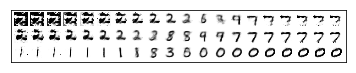

In [18]:
# Function which gives linear interpolation z_α between za and zb
def linear_interpol(za, zb, alpha):
    z = alpha * za + (1 - alpha) * zb
    return z

# Sample 3 pairs of data with different classes
def sample_pairs(data, labels, num=0):
    pairs = []
    for i in range(num):
        idx = torch.randint(data.shape[0], (2,))
        while torch.argmax(labels[idx[0]]) == torch.argmax(labels[idx[1]]):
            idx = torch.randint(data.shape[0], (2,))
        pairs.append(data[idx].float())
    return pairs

pairs = sample_pairs(train_images, train_labels, num=3)

# Encode the data in each pair, and take the mean vectors
mus = [encoder(x)[0] for x in pairs]

# Linearly interpolate between these mean vectors
alphas = torch.linspace(start, end, size)
interpols = []
for i in range(3):
    for alpha in alphas:
        interpols.append(linear_interpol(mus[i][0], mus[i][1], alpha).data.numpy())
interpols = np.stack(interpols)

theta = decoder(Variable(torch.from_numpy(interpols)))
thetas_np = theta.data.numpy()

# Concatenate these plots into one figure
fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_images(thetas_np, ax, ims_per_row=20)


# Posteriors and Stochastic Variational Inference

Here we will use numerical integration to plot the "true" posterior $p(z|x)$ which is generally intractable. We will compare the intractable true posterior to the variational approximate posterior given by the recognition model $q(z|x)$.

Then we will use the generative model to perform inference other inference tasks. In particular, we will see that the purpose of the encoder was only to make training the generative model tractable, and that we can do inference using the generative model completely without the encoder. To illustrate this we will perform the inference task of producing a generative distribution over the bottom half of the digit conditioned on the top half. We will achieve this with stochastic variational inference.

## Plotting Posteriors 

Here we will plot the true posterior by evaluating $\log p(x|z)+\log p(z)$ on an equally spaced grid over z then numerically integrating over this grid to find the log-normalizer $\log p(x)$. This will give us the intractable true posterior $p(z|x)$.

Then we will compare the true posterior to the approximate posterior given by the recognition model $q(z|x)$. Does the recognition model produce a good approximate posterior to the intractable true posterior?

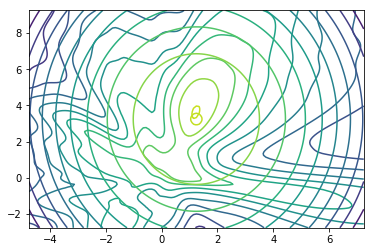

In [20]:
# Sample an element x from the dataset to plot posteriors for
x = train_images[np.random.randint(low = 0, high = len(train_images))].float().unsqueeze(dim=0)

# Define a grid of equally spaced points in z
# The grid needs to be fine enough that the plot is nice
# To keep the integration tractable 
# I reccomend centering your grid at the mean of q(z|x)
mu, log_sigma_squared = encoder(x)
mu = mu.data.numpy()
delta_z, std_dev = 0.1, 6
size = int((2 * std_dev) / delta_z + 1)

grid1, grid2 = np.linspace(mu[0][0] - std_dev, mu[0][0] + std_dev, int(size)), np.linspace(mu[0][1] - std_dev, mu[0][1] + std_dev, int(size))
grid = np.transpose([np.tile(grid1, len(grid1)), np.repeat(grid2, len(grid2))])
grid = Variable(torch.from_numpy(grid)).float()

# Evaluate log_p(x|z) + log_p(z) for every z on the grid
theta = decoder(grid)
probs = log_z_prior(grid) + log_cond_x(x, theta)

# Numerically integrate log_p(x|z) + log_p(z) to get log_p(x)
p_x = numerical_integration(probs, delta_z)

# print(p_x)
# Produce a grid of normalized log_p(z|x)
probs -= p_x
probs = probs.unsqueeze(1)

# Plot the contours of p(z|x) (note, not log)
plt.contour(grid1, grid2, probs.data.numpy().reshape(size,size), levels=10)

# Evaluate log_q(z|x) recognition network for every z on grid
log_q_z_x = log_z_post(grid, Variable(torch.from_numpy(mu)), log_sigma_squared)

# Plot the contours of q(z|x) on previous plot
plt.contour(grid1, grid2, log_q_z_x.data.numpy().reshape(size,size), levels = 10)
plt.show()

## True posterior for top of digit

In this question we will plot the "true" posterior given only the top of the image, $p(z|x_{top})$. 

Realize that the generative model gives a Bernoulli distribution over each pixel in the image. We can easily evaluate the likelihood of only the top of an image by evaluating under only those corresponding dimensions of the generative model.

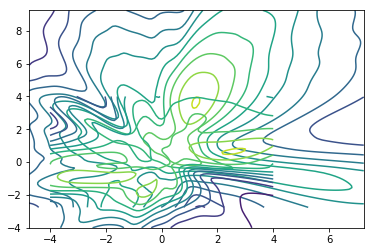

In [21]:
# Function which returns only the top half of a 28x28 array
# This will be useful for plotting, as well as selecting correct bernoulli params
def top_half(x):
    return x[:, :392]

# log_p(x_top | z) (hint: select top half of 28x28 bernoulli param array)
def log_p_top(x, theta):
    top = top_half(x)
    top_theta = top_half(theta)
    return log_cond_x(top, top_theta)

# Sample an element from the data set and take only its top half: x_top
x = train_images[np.random.randint(low = 0, high = len(train_images))].float().unsqueeze(dim=0)

# Define a grid of equally spaced points in z
delta_z, start, end = 0.1, -4, 4
size_top = int((end-start)/delta_z) + 1
grid_top = np.linspace(start, end, size_top)
grid = np.transpose([np.tile(grid_top, len(grid_top)), np.repeat(grid_top, len(grid_top))])
grid = Variable(torch.from_numpy(grid)).float()

# Evaluate log_p(x_top | z) + log_p(z) for every z on grid
theta = decoder(grid)
probs_top = log_p_top(x, theta) + log_z_prior(grid)

# Numerically integrate to get log_p(x_top)
p_x_top = numerical_integration(probs_top,delta_z)

# Normalize to produce grid of log_p(z|x_top)
probs_top -= p_x_top
probs_top = probs_top.unsqueeze(1)

# Plot the contours of p(z|x) (note, not log)
plt.contour(grid1, grid2, probs.data.numpy().reshape(size,size), levels = 10)

# Plot the contours of p(z|x_top)
plt.contour(grid_top, grid_top, probs_top.data.numpy().reshape(size_top,size_top), levels = 10)

plt.show()


## Learn approximate posterior for top of digit with Stochastic Variational Inference

In this question we will see how we can use SVI to learn an approximate posterior to $p(z|x_{top})$ which we just obtained through intractable integration.

Note that we can't just use our recognition model, because our encoder doesn't know what to do with only top halfs of images. Instead, we will initialize a variational distribution $q(z) = \mathcal{N}(z| \mu,\sigma I)$ and optimize the ELBO to minimize the KL divergence between it and the true distribution.

In [22]:
# Initialize parameters Î¼ and logÏƒ for variational distribution q(z)
mu = torch.rand(2, requires_grad=True)
log_sigma_squared = torch.rand(2, requires_grad=True)

# Define mean ELBO over M samples z ~ q(z)
# using log_p(z), log_p(x_top | z), and q(z|x_top)
def SVI_loss(decoder, M, mu, log_sigma_squared, x, z_s):
    mu = torch.stack([mu for i in range(M)])
    log_sigma_squared = torch.stack([log_sigma_squared for i in range(M)])
    theta = decoder(z_s)
    theta = top_half(theta)
    x = torch.stack([x for i in range(M)]).squeeze()
    x = top_half(x)
    
    return monte_carlo_estimate(x, z_s, theta, mu, log_sigma_squared)

# Loss for SVI is -1*ELBO
# Set up ADAM to optimize μ and logσ^2
optimizer = torch.optim.Adam([mu, log_sigma_squared], lr=0.01)
M = 100
z_s = torch.stack([sample_z(mu, log_sigma_squared) for i in range(M)])

# Optimize for a few iterations until convergence (you can use a larger stepsize here)
for i in range(30):
    print("Iteration: " + str(i+1))
    optimizer.zero_grad()
    z_s = torch.stack([sample_z(mu, log_sigma_squared) for i in range(M)])
    loss = SVI_loss(decoder, M, mu, log_sigma_squared, x, z_s)
    loss.backward()
    optimizer.step()
    print(loss)

Iteration: 1
tensor(104.3545, grad_fn=<MulBackward0>)
Iteration: 2
tensor(103.2299, grad_fn=<MulBackward0>)
Iteration: 3
tensor(103.8479, grad_fn=<MulBackward0>)
Iteration: 4
tensor(104.7959, grad_fn=<MulBackward0>)
Iteration: 5
tensor(105.1195, grad_fn=<MulBackward0>)
Iteration: 6
tensor(102.8463, grad_fn=<MulBackward0>)
Iteration: 7
tensor(104.8854, grad_fn=<MulBackward0>)
Iteration: 8
tensor(100.9935, grad_fn=<MulBackward0>)
Iteration: 9
tensor(100.6013, grad_fn=<MulBackward0>)
Iteration: 10
tensor(105.3627, grad_fn=<MulBackward0>)
Iteration: 11
tensor(107.0490, grad_fn=<MulBackward0>)
Iteration: 12
tensor(94.9589, grad_fn=<MulBackward0>)
Iteration: 13
tensor(107.9998, grad_fn=<MulBackward0>)
Iteration: 14
tensor(103.9290, grad_fn=<MulBackward0>)
Iteration: 15
tensor(100.4841, grad_fn=<MulBackward0>)
Iteration: 16
tensor(100.6231, grad_fn=<MulBackward0>)
Iteration: 17
tensor(98.8057, grad_fn=<MulBackward0>)
Iteration: 18
tensor(101.1899, grad_fn=<MulBackward0>)
Iteration: 19
tensor(

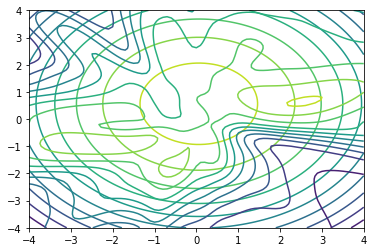

In [23]:
# On previous plot of contours of p(z|x_top) plot the optimized q(z)
mu_stacked = torch.stack([mu for i in range(len(grid))])
log_sigma_squared_stacked = torch.stack([log_sigma_squared for i in range(len(grid))])
probs_q = log_z_post(grid, mu_stacked, log_sigma_squared_stacked)

plt.contour(grid_top, grid_top, probs_q.data.numpy().reshape(size_top,size_top), levels = 10)
plt.contour(grid_top, grid_top, probs_top.data.numpy().reshape(size_top,size_top), levels = 10)
plt.show()

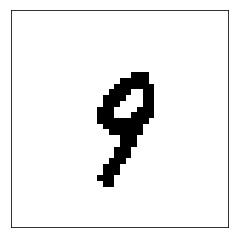

In [24]:
# Sample z ~ q(z)
z = sample_z(mu, log_sigma_squared)

# Use generative model p(x|z) to produce distribution over x
theta = decoder(z)

# Extract the bottom half of this generative distribution: p(x_bot| z)
bottom = theta[392:].data.numpy().reshape((1,392))
top = x.data.numpy()[:,:392]

# Concatenate the x_top and p(x_bot | z) and plot.
plot = np.hstack((top, bottom))

fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_images(x.data.numpy(), ax, ims_per_row = 1)

# Investigating Gradient Estimators

In this part we will experimentally investigate the difference in variances between the gradient estimates given by the Reparameterization and Score-Function gradient estimators.

Comment on their mean and variances